
# Introduction to K-Anonymity and Data Privacy
This notebook has been created to demonstrate the concepts of k-anonymity and differential privacy covered in the Security and Data Protection course of the MAADM Master's program. The notebook consists of:

1. Loading a dataset
2. Calculating k-anonymity
3. Performing modifications on the dataset to reduce the possibilities of re-identification of the included subjects

The goal is to understand how to protect individual privacy while maintaining the utility of the data for analysis.

In [1]:
# Importos Necesarios
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import invgamma
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import itertools

Dataset Download

In [2]:
#url = "https://drive.upm.es/s/RcwDAMg1bFAcDQZ/download"#Sin Income
url = "https://drive.upm.es/s/5wL1pmyhBMGpYOX/download"
dataset = pd.read_csv(url, sep=",", index_col=0)
dataset.head()


,SSN,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target,Income
DOB,,,,,,,,,,,,,,,,,,
9/7/1967,732-14-6110,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,24852
6/7/1988,150-19-2766,61523,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,26753
8/6/1991,725-59-9860,95668,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,27845
4/6/2009,659-57-4974,25503,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,19055
9/16/1951,220-93-3811,75387,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,24221


# Understanding K-Anonymity

K-anonymity is a concept in data privacy that measures how well a dataset protects individual privacy. A dataset is said to be k-anonymous if the information for each person contained in the dataset cannot be distinguished from at least k-1 other individuals whose information appears in the dataset.

To calculate k-anonymity:
1. We need to select quasi-identifiers (columns that could potentially identify an individual)
2. We group the data based on these quasi-identifiers
3. The k-anonymity value is the minimum number of records that share the same combination of quasi-identifier values

For example, if k=5, then any combination of quasi-identifiers must appear at least 5 times in the dataset.

In [3]:
def calculate_k_anonymity(df, quasi_identifiers):
    """
    Calculate k-anonymity for a dataset.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset to analyze
    quasi_identifiers : list
        List of column names that are considered quasi-identifiers

    Returns:
    --------
    int
        The k-anonymity value of the dataset
    dict
        Frequency distribution of equivalence classes
    """

    # Verify that all quasi-identifiers exist in the dataframe
    missing_columns = [col for col in quasi_identifiers if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Columns {missing_columns} not found in the dataframe")

    # Create a new dataframe with only the quasi-identifiers
    quasi_df = df[quasi_identifiers]
    quasi_df = quasi_df.copy()
    print(quasi_df._is_view)  # True if it's a view (slice), False if it's an independent DataFrame

    # Convert the quasi-identifiers to a string representation for grouping
    # This is needed to handle different data types in the quasi-identifiers
    quasi_df['combined'] = quasi_df.astype(str).apply(lambda x: '_'.join(x), axis=1)

    # Count the occurrences of each unique combination of quasi-identifiers
    counts = Counter(quasi_df['combined'])

    # The k-anonymity is the minimum frequency of any combination
    k_anonymity = min(counts.values()) if counts else 0

    # Calculate the frequency distribution
    freq_dist = {}
    for freq in counts.values():
        freq_dist[freq] = freq_dist.get(freq, 0) + 1

    return k_anonymity, freq_dist

Let's print the columns we have to get to know how we can use them later

In [4]:
# Assuming you have a DataFrame called df
column_list = dataset.columns.tolist()
# Let's print the available columns
print(column_list)

['SSN', 'Zip', 'Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num', 'Martial Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Country', 'Target', 'Income']


We will remove a few columns that are direct identifiers

In [5]:
to_exclude = ['Name','DOB','SSN','fnlwgt']

Let's measure k-anonymity with 4 quasi-identifiers

False
K-anonymity: 1
Frequency distribution: {5: 257, 9: 68, 40: 8, 6: 198, 13: 33, 1: 3821, 4: 383, 8: 103, 7: 124, 47: 2, 63: 4, 3: 709, 69: 4, 22: 13, 2: 1362, 26: 8, 17: 25, 12: 36, 140: 1, 42: 3, 216: 1, 187: 1, 67: 2, 16: 17, 23: 6, 65: 1, 57: 4, 87: 1, 62: 4, 11: 51, 91: 1, 92: 4, 46: 6, 55: 1, 33: 7, 113: 1, 53: 3, 176: 1, 73: 2, 51: 2, 14: 28, 110: 1, 24: 11, 38: 8, 34: 9, 10: 54, 15: 15, 66: 4, 29: 4, 72: 2, 21: 12, 58: 7, 43: 7, 30: 12, 50: 5, 35: 6, 61: 4, 104: 1, 59: 4, 60: 3, 37: 2, 19: 14, 56: 4, 101: 2, 133: 1, 108: 2, 36: 5, 31: 2, 75: 2, 86: 2, 68: 4, 41: 2, 39: 4, 74: 1, 64: 4, 76: 1, 52: 4, 28: 7, 54: 1, 89: 2, 79: 1, 116: 1, 49: 6, 25: 7, 85: 1, 44: 1, 20: 15, 77: 1, 98: 1, 18: 10, 83: 1, 45: 3, 48: 2, 90: 1, 32: 5, 95: 1, 27: 3, 112: 1}


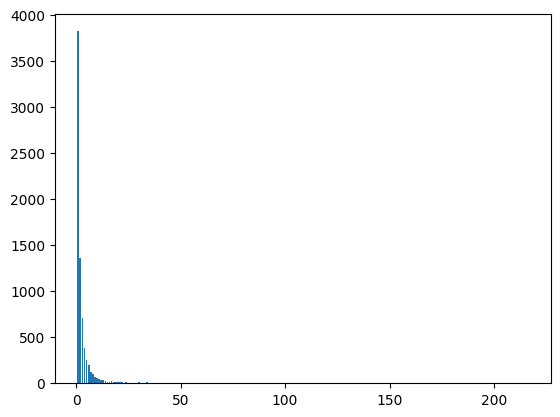

In [6]:
quasi_identifiers = ['Age', 'Workclass', 'Education', 'Relationship']
k_anonymity, freq_dist = calculate_k_anonymity(dataset, quasi_identifiers)
print(f"K-anonymity: {k_anonymity}")
print(f"Frequency distribution: {freq_dist}")

# Create the histogram/bar plot
plt.bar(freq_dist.keys(),freq_dist.values())
plt.show()


The dataset is 1-anonymous

# Task 1: Identify Entries that generate 1-anonymity
Your task is to identify the specific entries that are causing the 1-anonymity in the dataset. This will help understand which combinations of attributes make individuals uniquely identifiable.

Hint: Look for combinations of quasi-identifiers that appear only once in the dataset.

In [33]:
def find_one_anonymity_entries(df, quasi_identifiers: list[str]):
    """
    Finds entries in the dataset that result in 1-anonymity.

    Args:
        df: The input DataFrame.
        quasi_identifiers: A list of quasi-identifier column names.

    Returns:
        A DataFrame containing the entries that lead to 1-anonymity.
    """
    quasi_df = df[quasi_identifiers]
    quasi_df['combined'] = quasi_df.astype(str).apply(lambda x: '_'.join(x), axis=1)
    counts = Counter(quasi_df['combined'])
    one_anonymity_combinations = [key for key, value in counts.items() if value == 1]
    one_anonymity_entries = df[quasi_df['combined'].isin(one_anonymity_combinations)]
    print("*"*50)
    print(f"most common: {counts.most_common(1)}")
    print("*"*50)
    return one_anonymity_entries

In [34]:
one_anonymity_df = find_one_anonymity_entries(dataset, quasi_identifiers)
one_anonymity_df

**************************************************
most common: [('20_Private_Some-college_Own-child', 216)]
**************************************************


<ipython-input-33-3681df334d2d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quasi_df['combined'] = quasi_df.astype(str).apply(lambda x: '_'.join(x), axis=1)


,SSN,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target,Income
DOB,,,,,,,,,,,,,,,,,,
8/2/2001,535-53-2336,9820,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K,25194
8/10/2012,668-43-2767,92617,35,Federal-gov,76845,9th,5,Married-civ-spouse,Farming-fishing,Husband,Black,Male,0,0,40,United-States,<=50K,18778
7/15/1964,813-56-5466,93239,23,Local-gov,190709,Assoc-acdm,12,Never-married,Protective-serv,Not-in-family,White,Male,0,0,52,United-States,<=50K,24130
10/25/1954,602-74-4118,14378,48,Self-emp-not-inc,265477,Assoc-acdm,12,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K,30008
6/3/1971,534-46-2609,90260,47,Private,51835,Prof-school,15,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,1902,60,Honduras,>50K,34340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10/6/1976,235-28-4118,98532,71,NaN,287372,Doctorate,16,Married-civ-spouse,NaN,Husband,White,Male,0,0,10,United-States,>50K,22174
3/26/1995,859-26-1365,47690,45,State-gov,252208,HS-grad,9,Separated,Adm-clerical,Own-child,White,Female,0,0,40,United-States,<=50K,25613
6/6/1970,264-33-3644,80926,45,Local-gov,119199,Assoc-acdm,12,Divorced,Prof-specialty,Unmarried,White,Female,0,0,48,United-States,<=50K,24948


# Task 2: Optimize Column Selection

Try different combinations of columns to minimize the number of affected rows while maintaining data utility. The goal is to find the optimal balance between privacy and data usefulness.

Steps:
1. Try adding different combinations of columns
2. Calculate k-anonymity for each combination
3. Analyze which combination provides the best balance between privacy and data utility

# Task 3: Improve Dataset K-Anonymity

In this task, you'll modify the dataset to improve its k-anonymity by generalizing or aggregating values in the following columns:
- Age
- Workclass
- Education
- Relationship

The goal is to increase the k-anonymity value while preserving as much data utility as possible.

Consider using:
- Age ranges instead of exact ages
- Grouping education levels
- Simplifying workclass categories
- Generalizing relationship types

In [70]:
task2_dataset = dataset.copy()
quasi_identifiers = ['Age', 'Workclass', 'Education', 'Relationship']
task2_dataset['Age'] = "0-100"
one_anonymity_df = find_one_anonymity_entries(task2_dataset, quasi_identifiers)

**************************************************
most common: [('0-100_Private_HS-grad_Husband', 2915)]
**************************************************


<ipython-input-33-3681df334d2d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quasi_df['combined'] = quasi_df.astype(str).apply(lambda x: '_'.join(x), axis=1)


# Training the Dataset

In this section, we'll explore how k-anonymity affects the utility of the data for machine learning tasks. We'll use linear regression as our example and examine how different levels of privacy protection impact the model's performance.

# Task 4: Analyze Privacy-Utility Trade-off

Your task is to:
1. Train a linear regression model on the original dataset
2. Train the same model on datasets with different k-anonymity levels
3. Compare the model performance across different privacy levels
4. Analyze the trade-off between privacy protection and model accuracy

Steps:
1. Prepare the data for training
2. Train models on different privacy levels
3. Compare R² scores and other metrics
4. Visualize the trade-off between privacy and utility




In [ ]:
#** Añadir Aquí**

